# Modelo Ciclo Rankine

Importar librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Definir funciones

Para la temperatura y entropía en una isoterma e isoentrópica. Solo se eligen valores

In [2]:
from utils import saturated_diagram_ts, diagrama_ts, LABEL_SIZE, MARKER_SIZE

In [3]:
saturated_entropy, saturated_temperature = saturated_diagram_ts(0.0000, 9)

## Ciclo Ideal

### Definir valores a gráficar

In [4]:
vapor = pd.read_csv("tables/vapor_sobrecalentado.csv")
compress = pd.read_csv("tables/agua_comprimida.csv")
saturated = pd.read_csv("tables/agua_saturada_temperatura.csv")

# Fase Vapor
selected_vapor = vapor[vapor["P[kPa]"] == 5000]
# Se va muy arriba, para seleccionar menos
selected_vapor = selected_vapor[selected_vapor["s[kJ/kg·K]"] <= 7]

# Fase comprimida
selected_compress = compress[compress["P[kPa]"] == 5000]
# Las diferencias son muy pequeñas, para amplificarlas 
# a mayor temperatura menor diferencia
compress_entropy = selected_compress["s[kJ/kg·K]"]
compress_temperature = selected_compress["T[°C]"].copy()

length_compress = len(compress_entropy)
for i, entropy in enumerate(compress_entropy):
    beauty_delta = 50 * ((length_compress - i - 1) / length_compress)
    compress_temperature[i] += beauty_delta

T_c = selected_vapor["T[°C]"].iloc[0]

sat_s_g = saturated_entropy[76:]
sat_t_g = saturated_temperature[76:]
sat_s_f = saturated_entropy[:76]
sat_t_f = saturated_temperature[:76]

S_hielo = np.interp(T_c, sat_t_f, sat_s_f)
S_vapor = np.interp(T_c, sat_t_g[::-1], sat_s_g[::-1])

T_a = 100
S_a = np.interp(T_a, sat_t_f, sat_s_f)
S_b = S_a
T_b = np.interp(S_b, compress_entropy, compress_temperature)
T_ab = [T_a, T_b]
S_ab = [S_a, S_b]

# Presión constante
S_bc = [S_b] + list(compress_entropy[compress_entropy >= S_b])
T_bc = [T_b] + list(compress_temperature[compress_entropy >= S_b])

S_work_bomba = S_bc.copy()
T_work_bomba = T_bc.copy()

S_bc += [compress_entropy.iloc[-1], selected_vapor["s[kJ/kg·K]"].iloc[0]]
T_bc += [compress_temperature.iloc[-1], selected_vapor["T[°C]"].iloc[0]]

T_c = 400
S_c = np.interp(T_c, selected_vapor["T[°C]"], selected_vapor["s[kJ/kg·K]"])

S_work_turb = list(selected_vapor["s[kJ/kg·K]"][selected_vapor["T[°C]"] <= T_c]) + [S_c]
T_work_turb = list(selected_vapor["T[°C]"][selected_vapor["T[°C]"] <= T_c]) + [T_c]
S_bc += S_work_turb
T_bc += T_work_turb

S_d = S_c
S_cd = [S_c, S_d]

T_d = T_a
T_cd = [T_c, T_d]

S_da = [S_d, S_a]
T_da = [T_d, T_a]

In [5]:
S = [S_ab, S_bc, S_cd, S_da]
T = [T_ab, T_bc, T_cd, T_da]

### Graficar

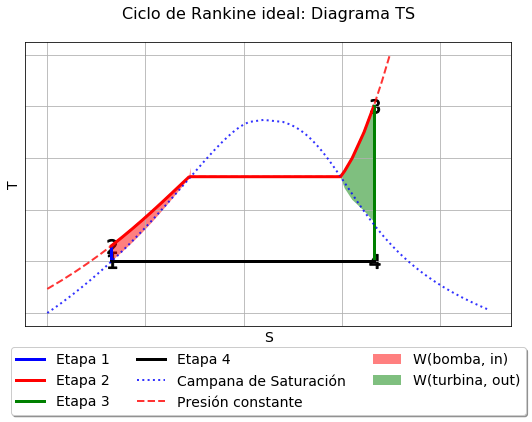

In [6]:
fig, ax = diagrama_ts(S, T, "Ciclo de Rankine ideal", True)
ax.plot(saturated_entropy, saturated_temperature, ":b", linewidth=2, alpha=0.8, label="Campana de Saturación")
constant_pressure_s = list(compress_entropy) + list(selected_vapor["s[kJ/kg·K]"])
constant_pressure_t = list(compress_temperature) + list(selected_vapor["T[°C]"])
ax.plot(constant_pressure_s, constant_pressure_t, "--r", linewidth=2, alpha=0.8, label="Presión constante")
S_delta = (S_work_bomba[-1] - S_work_bomba[0]) / 10
T_work_saturated = np.interp(np.linspace(S_work_bomba[0], S_work_bomba[-1] + S_delta, 10),
                             saturated_entropy,
                             saturated_temperature)
ax.fill_between(S_work_bomba,
                T_work_bomba,
                T_work_saturated,
                facecolor="r", alpha=0.5, label="W(bomba, in)")
S_delta = (S_work_turb[-1] - S_work_turb[0]) / 6
T_work_saturated_turb = np.interp(np.linspace(S_work_turb[0], S_work_turb[-1] + S_delta, 6),
                                  saturated_entropy,
                                  saturated_temperature)
ax.fill_between(S_work_turb,
                T_work_turb,
                T_work_saturated_turb,
                facecolor="g", alpha=0.5, label="W(turbina, out)")
ax.legend(fontsize=LABEL_SIZE, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=3, fancybox=True, shadow=True)
fig.tight_layout()

fig.savefig("../Matplotlib/ciclo_rankine_ts_ideal.png")

## Ciclo Real

### Definir valores a gráficar

In [7]:
S_b_real = S_b + ((S_work_bomba[-1] - S_b) / 3)
T_b_real = np.interp(S_b_real, compress_entropy, compress_temperature)

S_d_real_max = np.interp(T_d, sat_t_g[::-1], sat_s_g[::-1])
S_d_real = S_d + ((S_d_real_max - S_d) / 2)
T_d_real = T_d

### Graficar

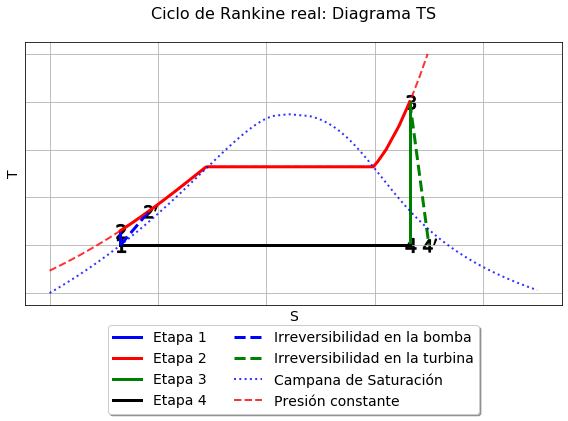

In [8]:
fig, ax = diagrama_ts(S, T, "Ciclo de Rankine real", True)
ax.scatter(S_b_real, T_b_real, marker='$2\'$', color='k', s=MARKER_SIZE)
ax.scatter(S_d_real, T_d_real, marker='$4\'$', color='k', s=MARKER_SIZE)
ax.plot([S_a, S_b_real], [T_a, T_b_real], "--b", linewidth=3, label="Irreversibilidad en la bomba")
ax.plot([S_c, S_d_real], [T_c, T_d_real], "--g", linewidth=3, label="Irreversibilidad en la turbina")
ax.plot(saturated_entropy, saturated_temperature, ":b", linewidth=2, alpha=0.8, label="Campana de Saturación")
ax.plot(constant_pressure_s, constant_pressure_t, "--r", linewidth=2, alpha=0.8, label="Presión constante")
ax.legend(fontsize=LABEL_SIZE, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=2, fancybox=True, shadow=True)
fig.tight_layout()

fig.savefig("../Matplotlib/ciclo_rankine_ts_real.png")